# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 28 ноября 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 28 ноября, -4 балла после 06:00 5 декабря, -6 баллов после 06:00 12 декабря, -8 баллов после 19 декабря

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush
Дополнительно нужно просто скинуть ссылку в slack в личный чат

Используйте данный Ipython Notebook при оформлении домашнего задания.

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from time import time

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

%load_ext pycodestyle_magic

In [2]:
# %%pycodestyle


class MyKmeans:

    def __init__(self, k=2, metric='euclidean', max_iter=1000,
                 random_state=None, init='random', tol=1e-2):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.init = init
        self.tol = tol
        if init == 'random':
            self.init_func = self.init_random
        elif init == 'k-means':
            self.init_func = self.init_kmeanspp

    def init_random(self, X, y=None):
        self.centroids = X[np.random.choice(X.shape[0], self.k)]

    def init_kmeanspp(self, X, y=None):
        self.centroids[0] = X[np.random.choice(X.shape[0])]
        dists = np.empty((X.shape[0], self.k))
        for k in range(1, self.k):
            dists[:, k - 1] = pairwise_distances(
                X, self.centroids[k - 1].reshape(1, -1),
                metric=self.metric
            ).reshape(-1)
            weights = dists[:, :k].min(axis=1)
            self.centroids[k] = X[np.random.choice(
                X.shape[0], p=weights / weights.sum()
            )]

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])

        # Массив с центроидами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))

        # Your Code Here
        self.init_func(X)
        for it in range(self.max_iter):
            dists = pairwise_distances(X, self.centroids,
                                       metric=self.metric)
            centroids_old = self.centroids.copy()
            self.labels = dists.argmin(axis=1)
            for k in range(self.k):
                cluster = X[self.labels == k]
                if cluster.size > 0:
                    self.centroids[k] = cluster.mean(axis=0)
            diff = mean_squared_error(self.centroids, centroids_old)
            if diff <= self.tol:
                break
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера

        Возвращает метку ближайшего кластера для каждого объекта
        """
        dists = pairwise_distances(X, self.centroids, metric=self.metric)
        return dists.argmin(axis=1)


class MiniBatchKMeans(MyKmeans):

    def __init__(self, *args, batch_size=500, **kwargs):
        super().__init__(*args, **kwargs)
        self.batch_size = batch_size

    def fit(self, X, y=None):
        """
        Процедура обучения MiniBatch-k-means
        """
        np.random.seed(self.random_state)
        self.labels = -np.ones(X.shape[0])
        self.centroids = np.empty((self.k, X.shape[1]))
        self.init_func(X)
        batch_size = min(self.batch_size, X.shape[0])
        for it in range(self.max_iter):
            batch_idx = np.random.choice(X.shape[0], batch_size)
            dists = pairwise_distances(X[batch_idx], self.centroids,
                                       metric=self.metric)
            centroids_old = self.centroids.copy()
            self.labels[batch_idx] = dists.argmin(axis=1)
            for k in range(self.k):
                cluster_idx = self.labels == k
                if cluster_idx.any():
                    self.centroids[k] = X[cluster_idx].mean(axis=0)
            diff = mean_squared_error(self.centroids, centroids_old)
            if diff <= self.tol:
                break
        self.labels = self.predict(X)
        return self


### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [3]:
from sklearn.datasets import make_blobs

In [4]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1,
                  center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

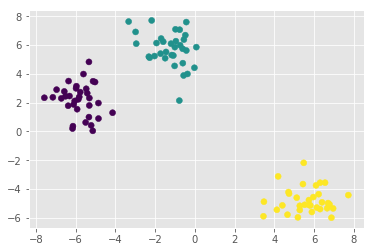

In [5]:
plt.scatter(X[:,0], X[:, 1], c=y)
# 0 - фиол, 1 - зел, 2 - желт

Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

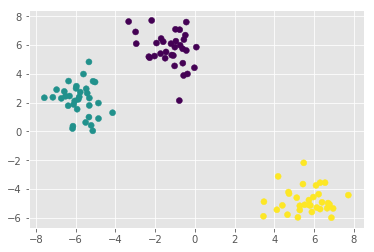

In [6]:
## Работоспособность MyKmeans
my_cls = MyKmeans(k=3, init='random', random_state=100).fit(X)
plt.scatter(X[:, 0], X[:, 1], c=my_cls.labels)

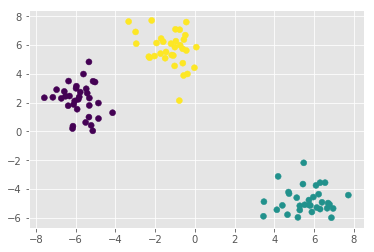

In [7]:
## Работоспособность MyKmeans++
my_cls = MyKmeans(k=3, init='k-means', random_state=100).fit(X)
plt.scatter(X[:, 0], X[:, 1], c=my_cls.labels)

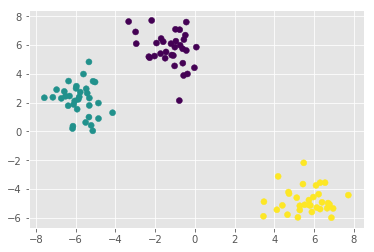

In [8]:
## Работоспособность MyKmeans с MiniBatchMyKmeans
my_cls = MiniBatchKMeans(k=3, init='random', batch_size=10, 
                         random_state=100).fit(X)
plt.scatter(X[:, 0], X[:, 1], c=my_cls.labels)

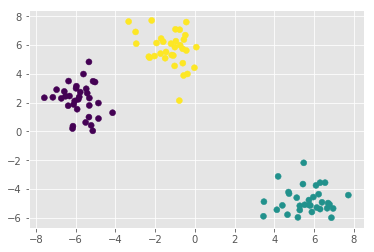

In [9]:
## Работоспособность MyKmeans++ с MiniBatchMyKmeans
my_cls = MiniBatchKMeans(k=3, init='k-means', batch_size=10, 
                         random_state=100).fit(X)
plt.scatter(X[:, 0], X[:, 1], c=my_cls.labels)

In [10]:
## Время выполнения алгоритма Kmeans из sklearn
cls = KMeans(n_clusters=3, init='random', tol=1e-2, random_state=100)
%time cls.fit(X)

CPU times: user 12.9 ms, sys: 0 ns, total: 12.9 ms
Wall time: 12.5 ms


KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=100, tol=0.01, verbose=0)

In [11]:
## Время выполнения алгоритма MyKmeans
my_cls = MyKmeans(k=3, init='random', random_state=100)
%time my_cls.fit(X)

CPU times: user 1.37 ms, sys: 104 µs, total: 1.47 ms
Wall time: 1.19 ms


In [12]:
## Время выполнения алгоритма MyKmeans++
my_cls = MyKmeans(k=3, init='k-means', random_state=100)
%time my_cls.fit(X)

CPU times: user 1.77 ms, sys: 0 ns, total: 1.77 ms
Wall time: 1.36 ms


In [13]:
## Время выполнения алгоритма MyKmeans с MiniBatchMyKmeans
my_cls = MiniBatchKMeans(k=3, init='random', batch_size=10, 
                         random_state=100)
%time my_cls.fit(X)

CPU times: user 3.17 ms, sys: 0 ns, total: 3.17 ms
Wall time: 2.8 ms


In [14]:
## Время выполнения алгоритма  MyKmeans++ с MiniBatchMyKmeans
my_cls = MiniBatchKMeans(k=3, init='k-means', batch_size=10, 
                         random_state=100)
%time my_cls.fit(X)

CPU times: user 3.61 ms, sys: 278 µs, total: 3.89 ms
Wall time: 3.64 ms


In [15]:
# получение данных для графика ниже
n_samples_vars = np.logspace(np.log(200), np.log(40000),
                             num=20, base=np.e).round().astype(int)
k = 5
durations = np.zeros((5, n_samples_vars.shape[0]))
n_inputs = 3
n_tests = 5
n_iters = 2
for j, n_samples in enumerate(n_samples_vars):
    for random_input in range(n_inputs):
        X_, y_ = make_blobs(n_samples=n_samples, n_features=2, centers=k,
                          cluster_std=1, center_box=(-30.0, 30.0),
                          shuffle=False, random_state=123+random_input)
        for random_state in range(123, 123+n_tests):
            for iters in range(n_iters):
                cls = [
                    MyKmeans(k=k, init='random',
                             random_state=random_state),
                    MyKmeans(k=k, init='k-means',
                             random_state=random_state),
                    MiniBatchKMeans(k=k, init='random', batch_size=500,
                                    random_state=random_state),
                    MiniBatchKMeans(k=k, init='k-means', batch_size=500,
                                    random_state=random_state),
                    KMeans(n_clusters=k, tol=1e-3,
                           random_state=random_state),
                ]
                for i, c in enumerate(cls):
                    time1 = time()
                    c.fit(X_)
                    time2 = time()
                    durations[i][j] += time2 - time1
durations /= n_tests * n_inputs * n_iters

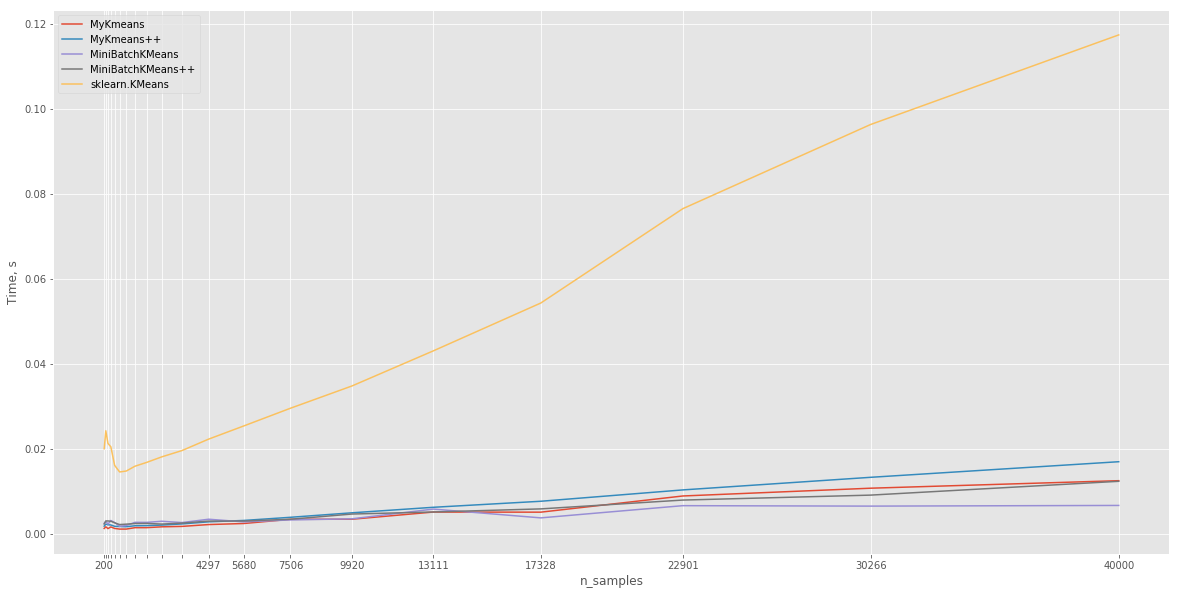

In [16]:
# график зависимости времени выполнения от объёма данных
names = ['MyKmeans', 'MyKmeans++',
         'MiniBatchKMeans', 'MiniBatchKMeans++', 'sklearn.KMeans']
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
for i in range(5):
    ax.plot(n_samples_vars, durations[i], label=names[i])
plt.xlabel('n_samples')
plt.ylabel('Time, s')
plt.xticks(n_samples_vars,
           [x if x > 4200 or i == 0 else ''
            for i, x in enumerate(n_samples_vars)])
ax.legend()

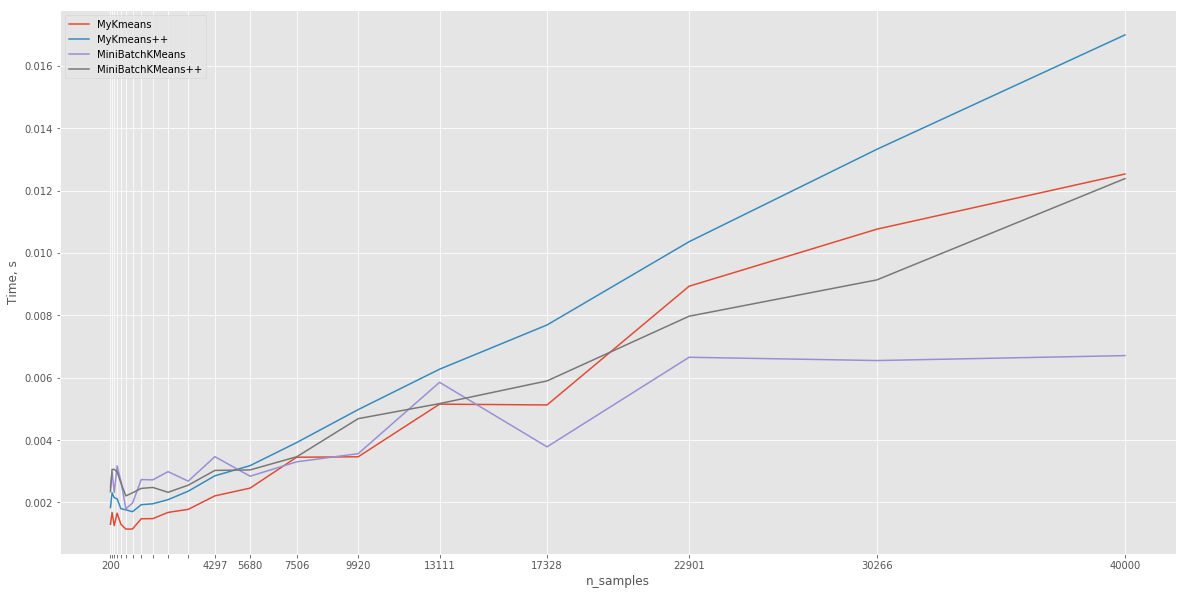

In [17]:
# этот же график, но без sklearn.kmeans и в другом масштабе
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
for i in range(4):
    ax.plot(n_samples_vars, durations[i], label=names[i])
plt.xlabel('n_samples')
plt.ylabel('Time, s')
plt.xticks(n_samples_vars,
           [x if x > 4200 or i == 0 else ''
            for i, x in enumerate(n_samples_vars)])
ax.legend()

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [18]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [19]:
df_sns.drop(["gradyear", "gender", "age", "friends"], axis=1, inplace=True)
df_norm = (df_sns - df_sns.mean()) / df_sns.std()
X = df_norm.values
k = 9

In [20]:
def df_sns_print_clusters(labels):
    clusters = df_sns.groupby(labels)
    sorted_idx = np.argsort(-clusters.size())
    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(111)
    plt.bar(np.arange(k), clusters.size()[sorted_idx])
    details = []
    for i in range(k):
        clst = clusters.mean().loc[sorted_idx[i]].sort_values(ascending=False)
        s = f"{sorted_idx[i]}:\n" \
            + "\n".join("{0:14} {1:0.1f}".format(
                clst.index[j], clst.values[j]) for j in range(10)
            )
        details.append(s)
    plt.xticks(np.arange(k), details)

CPU times: user 161 ms, sys: 63.9 ms, total: 225 ms
Wall time: 117 ms


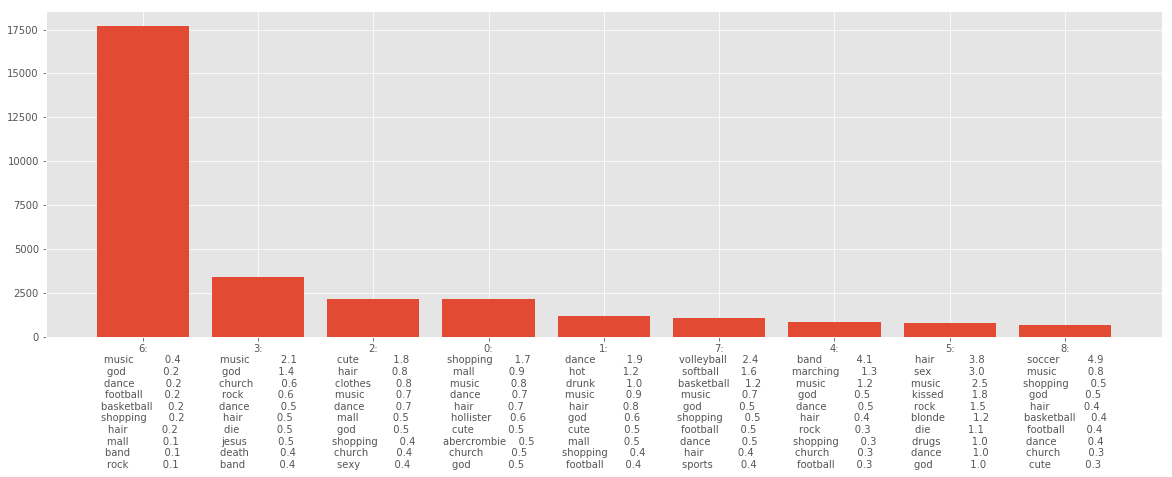

In [21]:
## MyKMeans
%time my_cls = MyKmeans(k=k, init='random', random_state=1).fit(X)
df_sns_print_clusters(my_cls.labels)

CPU times: user 157 ms, sys: 40.2 ms, total: 198 ms
Wall time: 108 ms


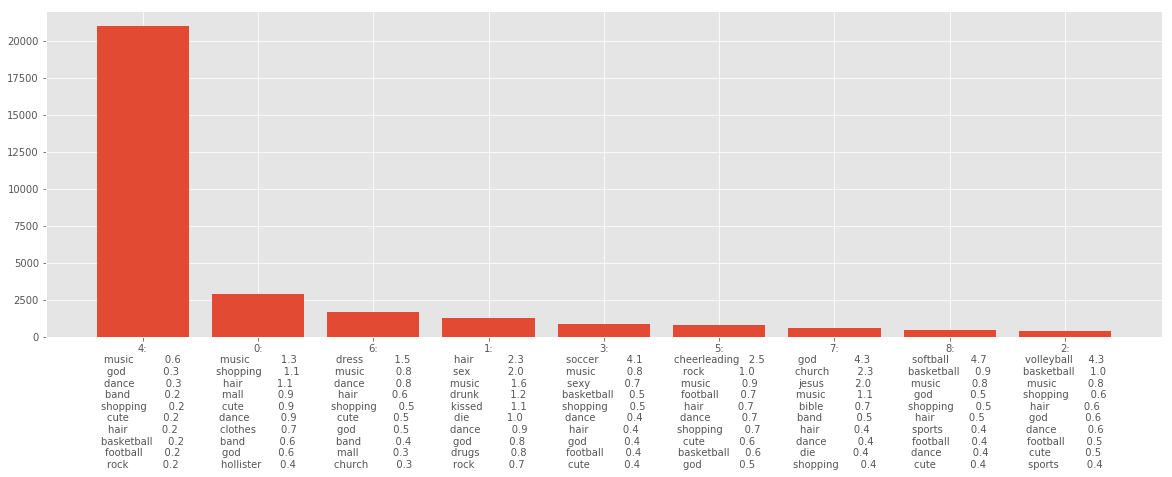

In [22]:
## MyKMeans++
%time my_cls = MyKmeans(k=k, init='k-means', random_state=1).fit(X)
df_sns_print_clusters(my_cls.labels)

CPU times: user 30.4 ms, sys: 0 ns, total: 30.4 ms
Wall time: 18.5 ms


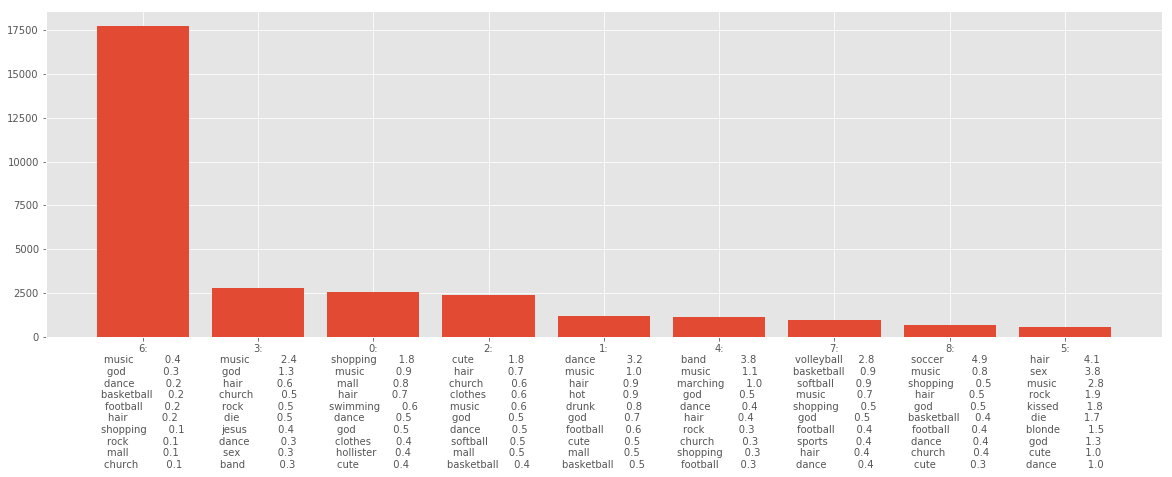

In [23]:
## MyKMeans с MiniBatchMyKMeans
%time my_cls = MiniBatchKMeans(k=k, init='random', batch_size=1000, random_state=1).fit(X)
df_sns_print_clusters(my_cls.labels)

CPU times: user 61.6 ms, sys: 28 ms, total: 89.7 ms
Wall time: 46 ms


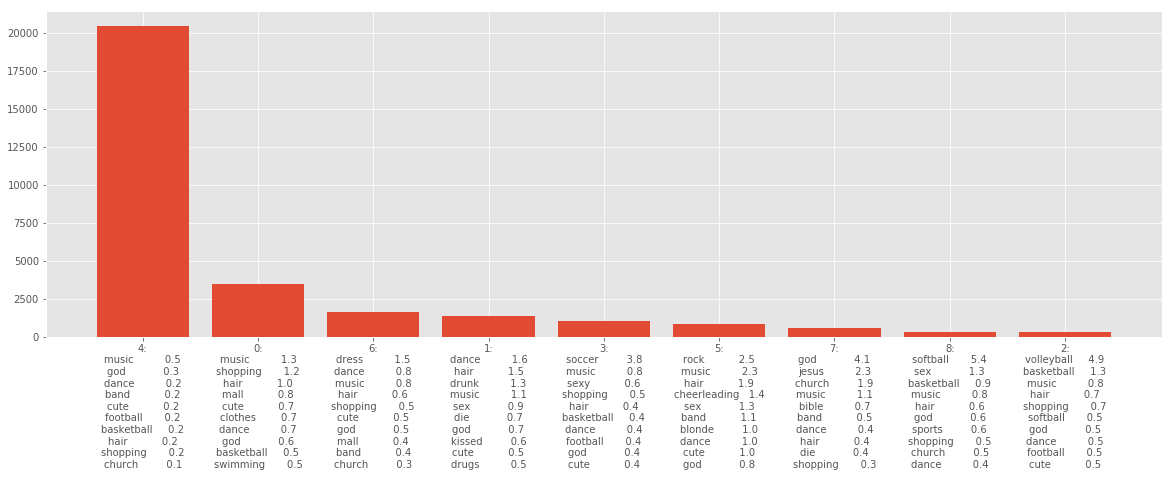

In [24]:
## MyKMeans++ с MiniBatchMyKMeans
%time my_cls = MiniBatchKMeans(k=k, init='k-means', batch_size=1000, random_state=1).fit(X)
df_sns_print_clusters(my_cls.labels)

В кластеризациях, полученных 4 комбинациями параметров, прослеживаются кластеры людей, увлекающихся футболом или волейболом, черлидеров, группы людей с разной степенью активности и "безбашенности" образа жизни (sex, drugs & rock'n'roll) или просто любителей музыки, любителей шоппинга, глубоко верующих людей.

Все 4 комбинации (параметров) показывают похожий результат, ибо во всех вариантах прослеживаются почти одни и те же группы людей, описанные выше. Но при разных random_state для каждой из 4 комбинаций размеры этих кластеров сильно колеблются (хотя самый большой кластер всё равно никому не уступает по своему размеру), поэтому сложно определить на глаз, какой из алгоритмов показывает лучший результат на реальных данных.


In [25]:
## Вывод

k-means++ хоть и немного медленнее случайной инициализации (собственно за счёт самой процедуры инициализации), но  более вероятно даст корректную кластеризацию, поэтому его стоит предпочесть случайной инициализации. Но даже в этом случае нужно прогонять алгоритм несколько раз с разными результатами генерации случайных чисел (хотя логика алгоритма k-means++ обещает, что прогонов можно делать меньше, чем для случайной инициализации - это может скомпенсировать недостаток в скорости k-means++).

MiniBatch работает быстрее, особенно на больших данных (для чего и был создан), но качество кластеризации может быть хуже, чем у обычного k-means. Поэтому нужно сбалансированно выбрать значение параметра batch_size, чтобы он был не слишком маленький (для качества), но и меньше, чем объём данных (для скорости и памяти). Не очень ясно, что лучше из MiniBatch и обычного k-means, но для больших данных MiniBatch будет сильно полезен.